# Statistical Foundations of Machine Learning Project

#### Name : Student number:

#### 1-Nicolas Anthony Rowies : 0547647
#### 2-Harunah Lamini : 0608288 
#### 3-Faleu Kemajou Loic : 0598272

We worked on the following research questions:

#### 1-What is the impact of mislabeled training examples/outliers on the performance?
#### 2-How do ensemble methods, such as bagging and boosting, mitigate overfitting compared to single models?
#### 3-In the case of SVM, what is the impact of class overlap, class unbalance and mislabeled data on the number and location of support vectors?


For this project our team methodology was to each choose a research question and develop it. We choose to meet once a week to discuss our individual advancements and helped each when this was needed. At the end of our research, when we merged our research questions, we also proceeded to do a peer review of each other to ensure a qualitative project. 

# RESEARCH QUESTION 1

# ***What is the impact of mislabeled training examples/outliers on the performance?***

## Introduction 

In this experiment we will analyze the impact of outliers on a regression model. We will do this by using a synthetic dataset, creating one dataset with outliers and one without. The goal is to train two identical models on these different datasets and measure the impact of the outliers on the learning process. The regression problem will be given two parameters and will have the guess the height of the a wave pattern.

## Synthetic Data 

First we implement the training and test data sets. For the ease of use we will create a function that creates the data set with parameters: number of samples, number of outliers and noise. For the implementation self, we first implement a flat plane, then bring the mathematical function using sinus and cosinus to get the wavery relationship of the data. Then we add some noise based on the standard deviation and a parameter for the intensity and finally we add the outliers (if necessary, depending on the variable). 

We proceed finally by using the function we just created to create our multiple training and testing data sets. One without outliers, one with outliers and then one without outliers nor noise, to correctly compare both models on the underlying target function that we camouflaged with noise.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

outliers_percentage = 0.1 

extremes = 10
noise_std_dev = 0.5

training_samples = 250 
test_samples = 50 

def generate_data(num_samples, outliers, noise_std_dev):
    
    # Flat plane 
    num_normal_samples = int(num_samples * (1 - outliers))
    x1 = np.linspace(-extremes, extremes, num_normal_samples)
    x2 = np.linspace(-extremes, extremes, num_normal_samples)
    x1, x2 = np.meshgrid(x1, x2)
    y = np.zeros_like(x1)
    
    # Plane modifications 
    movement_amplitude = 5
    movement_frequency = 0.15
    y += movement_amplitude * np.sin(movement_frequency * x1) * np.cos(movement_frequency * x2)

    # Adding noise
    y += np.random.normal(0, noise_std_dev, y.shape)

    # Update into flat array 
    x1 = x1.ravel()
    x2 = x2.ravel()
    y = y.ravel()
    x = np.vstack([x1, x2]).T

    # Add outliers (extreme noise)  
    num_outliers = int(outliers * num_samples)
    outliers_x1 = np.random.uniform(-extremes, extremes, num_outliers)
    outliers_x2 = np.random.uniform(-extremes, extremes, num_outliers)
    outliers_y = np.random.uniform(-extremes, extremes, num_outliers)
    x_outliers = np.vstack([outliers_x1, outliers_x2]).T
    x = np.vstack([x, x_outliers])

    # Add final target set 
    y = np.concatenate([y, outliers_y])

    return x, y

# Create the different training/test data sets 
x_train, y_train = generate_data(training_samples, 0, noise_std_dev)
x_train_outliers, y_train_outliers = generate_data(training_samples, outliers_percentage, noise_std_dev)

# Target distribution (optimal goal)
x_test_goal, y_test_goal = generate_data(test_samples, 0, 0)

## Visualisation

We proceed to visualise the data sets, left the data set without outliers and right with outliers.

In [ ]:
def plot_data(x_train, y_train, title, ax):
    ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c='blue', label='Train data', alpha=0.05)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    ax.legend()
    ax.set_title(title)

fig = plt.figure(figsize=(20, 8))

# Left plot 
ax1 = fig.add_subplot(121, projection='3d')
plot_data(x_train, y_train, 'Data without outliers', ax1)

# Right plot 
ax2 = fig.add_subplot(122, projection='3d')
plot_data(x_train_outliers, y_train_outliers, 'Data with outliers', ax2)

plt.show()

## Model & techniques

For this experiment, the model is a neural network using stochastic gradient descent. It will have three hidden layers: the first two layers will each have 64 neurons, and the last hidden layer will have 32 neurons. The complete model architecture will be: 2-64-64-32-1. Additionally, there is a scheduler to decrease the learning rate over time, optimizing the training process and increasing learning speed due. An early stopping callback is also used to determine the most optimal number of epochs, but this was only for assessment purposes. Otherwise, it could lead to higher variance in the results due to differing epoch counts between each model.




In [ ]:
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def create_model():
    model = keras.Sequential([
        layers.Dense(64, input_dim=2, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0004)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    if lr < 0.0001:
        lr = 0.0001
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=25,         
    restore_best_weights=True  
)

### Model 1 : Normal training

Here we simply train the model created previously with the training data without outliers. 

In [ ]:
model1 = create_model()

history = model1.fit(x_train, y_train,
                    epochs=50, 
                    validation_split=0.2,
                    callbacks=[lr_scheduler]) # early_stopping 

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 : Outlier training

Here we do the same but this time with the data we created previously with outliers. 

In [ ]:
model2 = create_model()

history = model2.fit(x_train_outliers, y_train_outliers,
                    epochs=50, 
                    validation_split=0.2,
                    callbacks=[lr_scheduler]) # early_stopping 

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation of both models

Here we do compare both models we just trained to see the differences on the test_goal data set, which represented the underlying target distribution. So this is ultimately the test to see their performances and compare. To better visualize we also added a different angle to see how good the model adapts on the targets and we can see how it tries to approximate, the difference could be even seen between both models on the plots.  

In [ ]:
test_loss, test_mae = model1.evaluate(x_test_goal, y_test_goal)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')
test_outliers_loss, test_outliers_mae = model2.evaluate(x_test_goal, y_test_goal)
print(f'Test outliers Loss: {test_outliers_loss}, Test MAE: {test_outliers_mae}')

y_pred = model1.predict(x_test_goal)
y_pred_outliers = model2.predict(x_test_goal)

fig = plt.figure(figsize=(20, 20))

# With outliers top-left
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_test_goal, color='blue', label='Actual')
ax1.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_pred, color='red', label='Predicted')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')
ax1.set_title('Without outliers')
ax1.legend()

# Without outliers top-right
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_test_goal, color='blue', label='Actual')
ax2.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_pred_outliers, color='red', label='Predicted')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Y')
ax2.set_title('With outliers')
ax2.legend()

# Rotated view without outliers bottom-left
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_test_goal, color='blue', label='Actual')
ax3.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_pred, color='red', label='Predicted')
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_zlabel('Y')
ax3.set_title('Without outliers')
ax3.view_init(elev=10, azim=90)
ax3.legend()

# Rotated view with outliers bottom-right
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_test_goal, color='blue', label='Actual')
ax4.scatter(x_test_goal[:, 0], x_test_goal[:, 1], y_pred_outliers, color='red', label='Predicted')
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_zlabel('Y')
ax4.set_title('With outliers')
ax4.view_init(elev=10, azim=90)
ax4.legend()

plt.show()

## Statistical analysis : With- versus without outliers training

Because the training sessions can sometimes lead to slightly different performances, a statistical analysis can be a good way to correctly compare two training methods. The goal here is to execute a number of N times the training of each model and evaluate those models performances. Then put the evaluations in a statistical figure to correctly asses the differences of the trainings. In this case we believe a boxplot is the most adequate figure to use to compare and highlight the performances on the multiple trainings. 

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

n_iterations = 30
n_epochs = 50

results_model1 = []
results_model2 = []

def create_model():
    model = keras.Sequential([
        layers.Dense(64, input_dim=2, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0004)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    if lr <= 0.0001:
        lr = 0.0001
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

for i in range(n_iterations):
    print(f"Iteration {i+1}")

    # Create 
    model1 = create_model()
    model2 = create_model()

    # Training model 1
    history1 = model1.fit(x_train_0, y_train_0, 
                             epochs=n_epochs,
                             validation_split=0.2,
                             callbacks=[lr_scheduler],
                             verbose=2)
        
    test_loss1, test_mae1 = model1.evaluate(x_test_goal, y_test_goal, verbose=0)
    results_model1.append((test_loss1, test_mae1))
    print(f"Model1 - Iteration {i+1} - Test loss: {test_loss1:.4f}, Test MAE: {test_mae1:.4f}")

    # Training model 2 
    history2 = model2.fit(x_train_outliers_0010, y_train_outliers_0010,
                             epochs=n_epochs,
                             validation_split=0.2,
                             callbacks=[lr_scheduler],
                             verbose=2)
        
    test_loss2, test_mae2 = model2.evaluate(x_test_goal, y_test_goal, verbose=0)
    results_model2.append((test_loss2, test_mae2))
    print(f"Model2 - Iteration {i+1} - Test loss: {test_loss2:.4f}, Test MAE: {test_mae2:.4f}")

        
results_model1 = np.array(results_model1)
results_model2 = np.array(results_model2)

results_df = pd.DataFrame({
    'Model': ['Without outliers'] * n_iterations + 
             ['With outliers'] * n_iterations, 
    'Test loss': np.concatenate((results_model1[:, 0], results_model2[:, 0])),
    'Test MAE': np.concatenate((results_model1[:, 1], results_model2[:, 1]))
})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Model', y='Test loss', data=results_df)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
sns.boxplot(x='Model', y='Test MAE', data=results_df)
plt.xticks(rotation=15)

plt.tight_layout()
plt.savefig('model_performance_plots.png')
plt.show()

## Improvement : Huber loss

To try to offset as good as possible the outliers impact on the performance of the model there are multiple techniques that could be used. One of those techniques is using another loss function, instead of using the mean squared error loss function which penalises extremely hard points very far from its target point and therefore the outliers. We could use the Huber loss function, which behaves as the mean squared error for close errors but further away as the mean absolute error. Which will mitigate the penalty a little from further points without losing too much of its efficiency. To make this work it uses a delta:
:$$
L_\delta(y,f(x)) =
\begin{cases} 
\frac{1}{2} (y - f(x))^2 & \text{for } |y - f(x)| \leq \delta , \\
\delta (|y - f(x)| - \frac{1}{2} \delta) & \text{for } |y - f(x)| > \delta
\end{cases}
$$

(source: https://en.wikipedia.org/wiki/Huber_loss)

<div style="text-align: center;">
    <img src="https://www.researchgate.net/profile/Nasser-Sadeghkhani/publication/332098244/figure/fig1/AS:742155601575937@1553955092529/Comparison-of-Huber-L-2-least-square-and-L-1-absolute-error-loss-functions-in-11.ppm" alt="Graph" style="width: 300px;"/>
</div>

# Statistical analysis : Huber loss versus mean squared loss on data with outliers

To experiment this change in our models we can try to compare this time two different models given the same training data with outliers. In that way we could see how the different models will perform based on the training. This experiment is done in a similar way as the precedent experiment using multiple training sessions to have a better chance to see there real performances on average. The higher the N, the higher the probability of a precise answer.

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

n_iterations = 10
n_epochs = 50

results_model1 = []
results_model2 = []

def create_model():
    model = keras.Sequential([
        layers.Dense(64, input_dim=2, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0004)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

def create_robust_model():
    model = keras.Sequential([
        layers.Dense(64, input_dim=2, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.0004)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.Huber(delta=1.0),
                  metrics=['mae'])
    return model

def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    if lr <= 0.0001:
        lr = 0.0001
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

for i in range(n_iterations):
    print(f"Iteration {i+1}")
        
    model1 = create_robust_model()
    model2 = create_model()
        
    history1 = model1.fit(x_train_outliers, y_train_outliers,
                             epochs=n_epochs,
                             validation_split=0.2,
                             callbacks = [lr_scheduler],
                             verbose=2)
        
    test_loss1, test_mae1 = model1.evaluate(x_test_goal, y_test_goal, verbose=0)
    results_model1.append((test_loss1, test_mae1))
    print(f"Model1 - Iteration {i+1} - Test loss: {test_loss1:.4f}, Test MAE: {test_mae1:.4f}")
                
    history2 = model2.fit(x_train_outliers, y_train_outliers,
                             epochs=n_epochs,
                             validation_split=0.2,
                             callbacks = [lr_scheduler],
                             verbose=2)
        
    test_loss2, test_mae2 = model2.evaluate(x_test_goal, y_test_goal, verbose=0)
    results_model2.append((test_loss2, test_mae2))
    print(f"Model2 - Iteration {i+1} - Test loss: {test_loss2:.4f}, Test MAE: {test_mae2:.4f}")

       
results_model1 = np.array(results_model1)
results_model2 = np.array(results_model2)

results_df = pd.DataFrame({
    'Model': ['Robust model (with outliers)'] * n_iterations + ['Normal model (with outliers)'] * n_iterations,
    'Test loss': np.concatenate((results_model1[:, 0], results_model2[:, 0])),
    'Test MAE': np.concatenate((results_model1[:, 1], results_model2[:, 1]))
})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Model', y='Test loss', data=results_df)
plt.title('Box Plot of Test Loss')

plt.subplot(1, 2, 2)
sns.boxplot(x='Model', y='Test MAE', data=results_df)
plt.title('Box Plot of Test MAE')

plt.tight_layout()
plt.savefig('model_performance_plots.png')
plt.show()

## Conclusion

In this experiment, we can conclude two things:

## Influence of outliers
The first conclusion concerns the effect of outliers on the performance of models. When outliers are present in the training data, they increase the likelihood of a model performing poorly on future data. The more outliers in the training data, the bigger the probability of poor performance. However, we observe that with around 2.5% outliers, the impact is smaller. Therefore, we can conclude that a small percentage of outliers would minimally decrease the model's performance. The acceptable level of outliers likely depends on the model, data, and other factors. For this experiment, approximately 2% or fewer outliers seems to be an acceptable level.



### Boxplot with 2.5% outliers

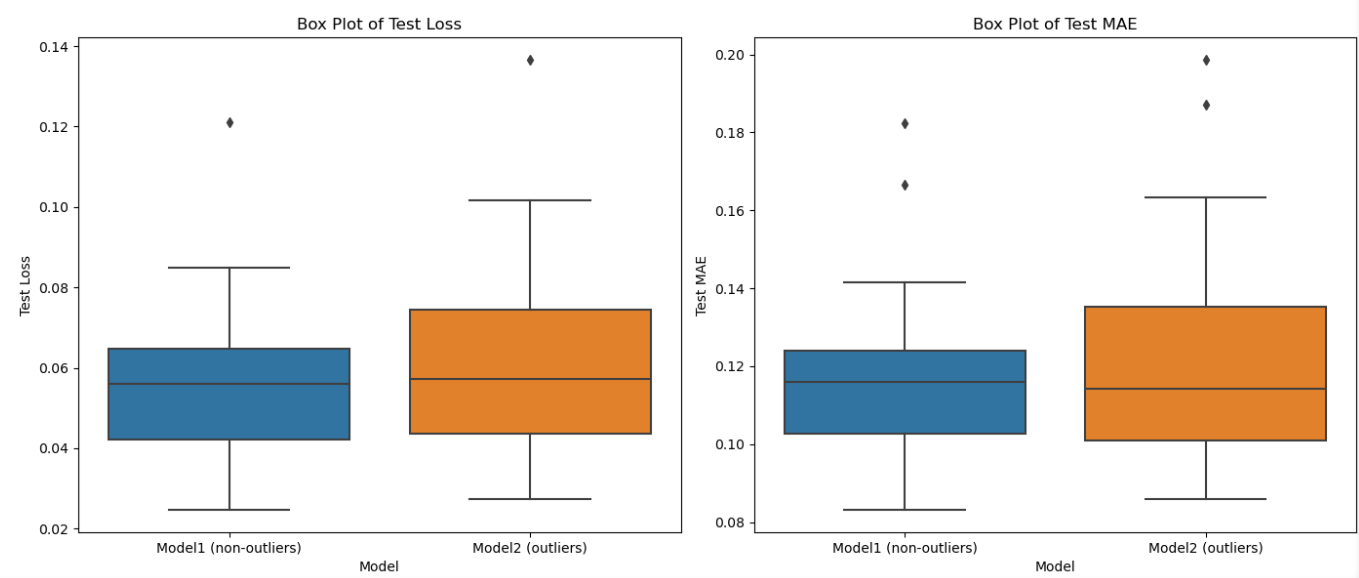

In [5]:
from IPython.display import Image
from IPython.display import display

x = Image(filename='SFML - Boxplot - 2,5% outliers - 0.5 noise.png',width=800, height=500) 
display(x)

### Boxplot with 5% outliers

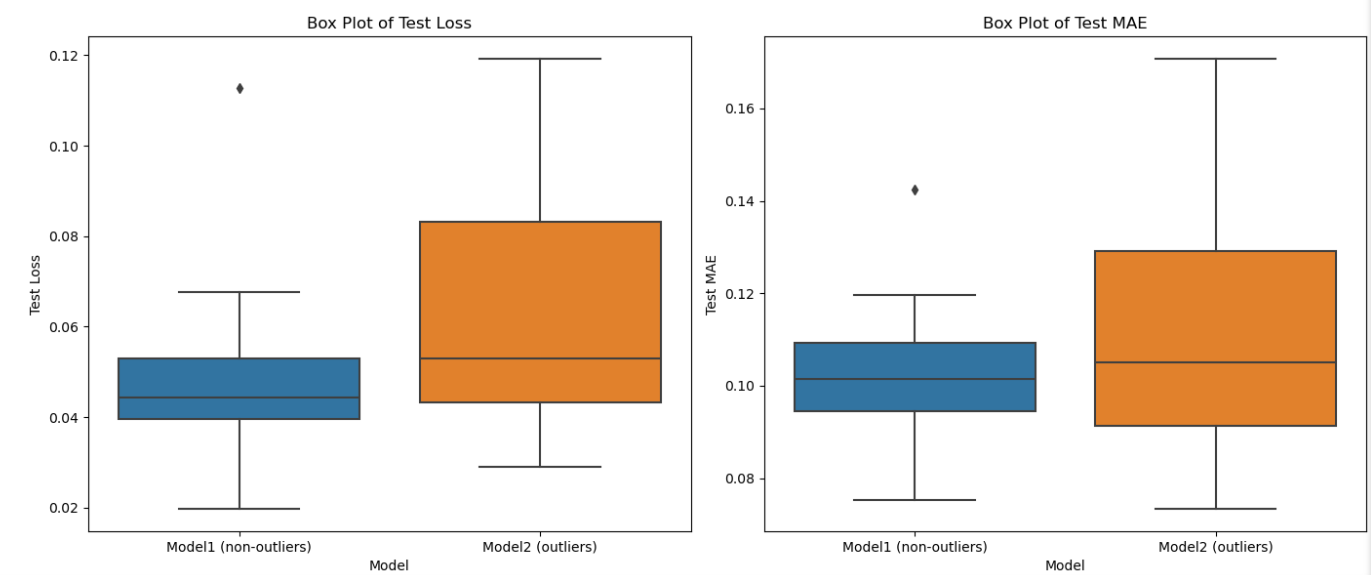

In [6]:

z=Image(filename='SFML - Boxplot - 5% outliers - 0.5 noise.png',width=800, height=500) 
display(z)

### Boxplot with 20% outliers

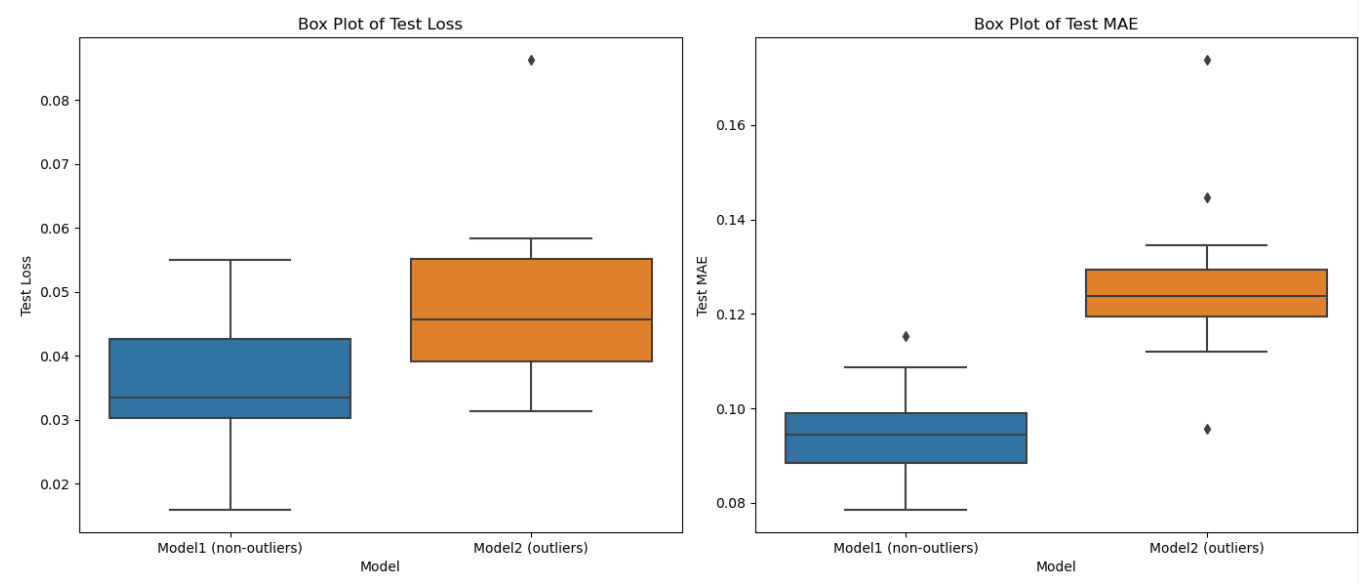

In [7]:
y = Image(filename='SFML - Boxplot - 20% outliers - 0.5 noise.png',width=800, height=500) 
 
display(y)

## Huber loss function 
The second conclusion is about the techniques that could be used to mitigate the impact of outliers on performance. One technique could be using a Huber loss function, which penalizes misclassifications more gradually. Tests on the data indicate that this approach has a positive effect on reducing loss on all outliers percentages. Further research should be done to asses for example the influence of the $\delta$ chosen, for example if knowingly there will be outliers with a very high degree of misclassifications a higher $\delta$ could be interesting to use without influencing the rest of the training data. 


### Boxplot with 2.5% outliers

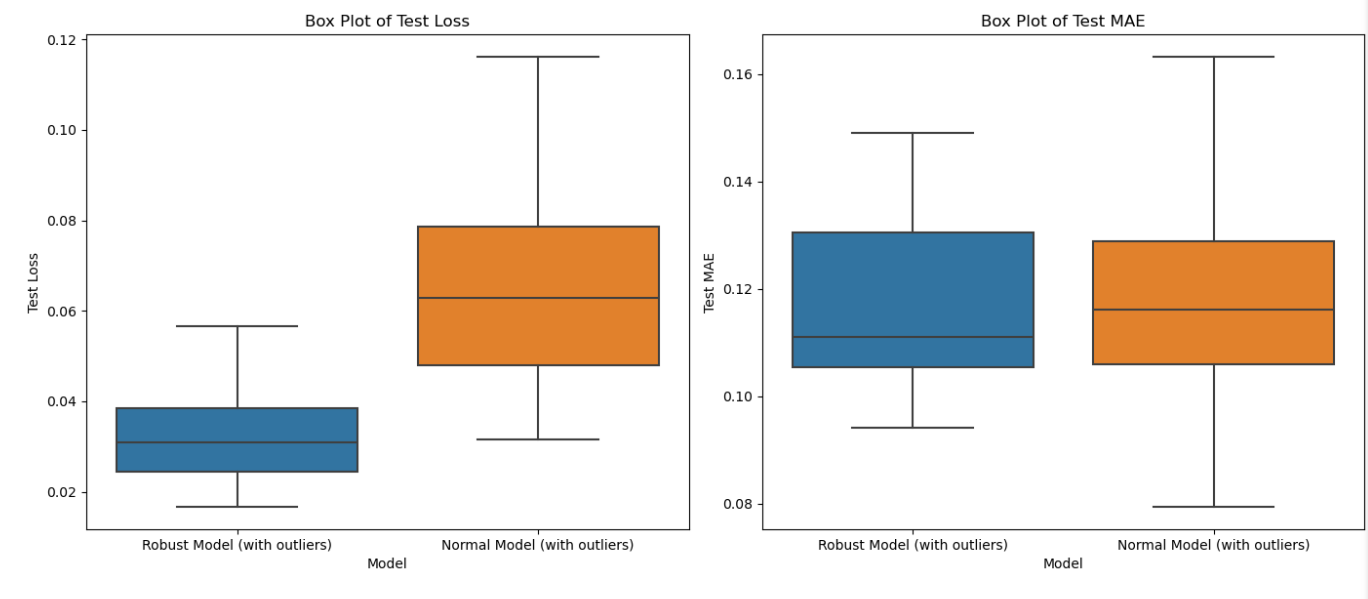

In [22]:
x = Image(filename='SFML - Boxplot - 2,5% outliers - 0.5 noise - Robust.png',width=800, height=500) 
display(x)

### Boxplot with 5% outliers

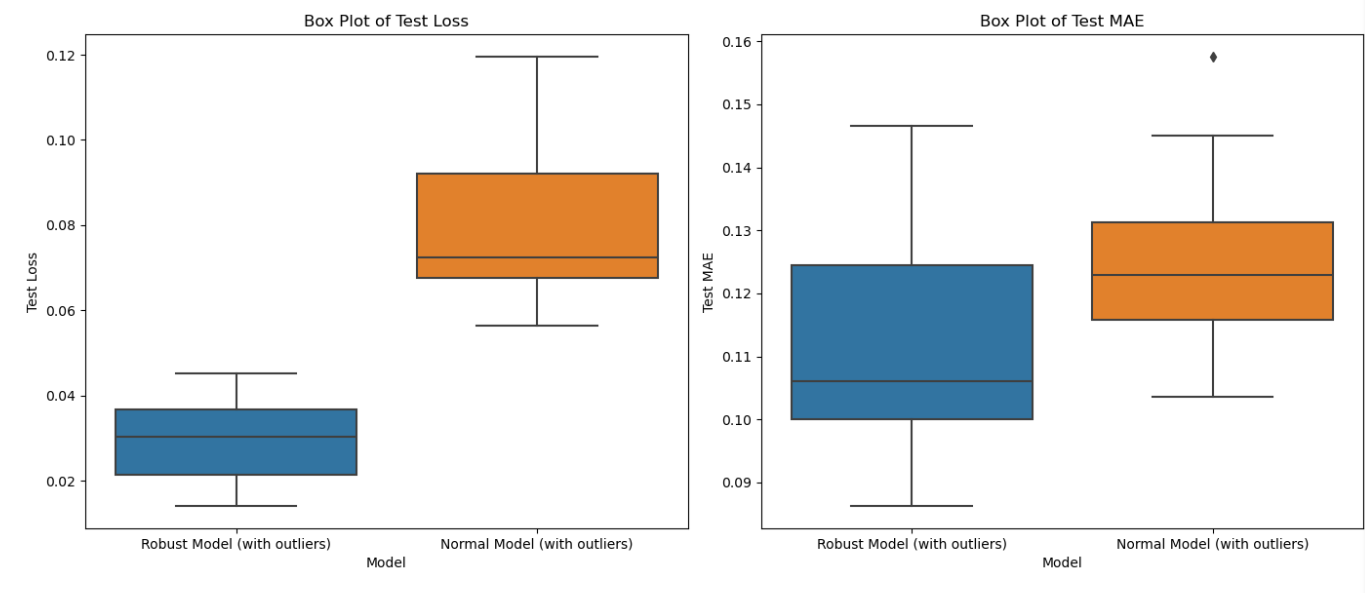

In [23]:
y = Image(filename='SFML - Boxplot - 5% outliers - 0.5 noise - Robust.png',width=800, height=500) 
display(y)

### Boxplot with 10% outliers

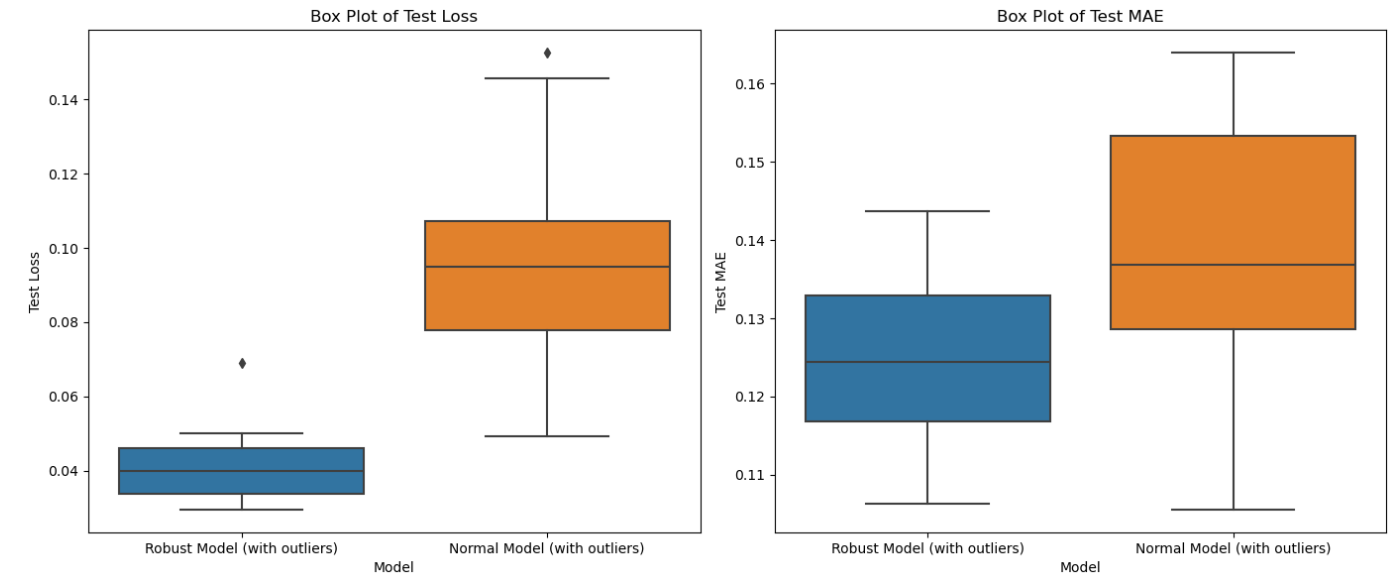

In [26]:
z = Image(filename='SFML - Boxplot - 10% outliers - 0.5 noise - Robust.png',width=800, height=500) 
display(z)


### Final word
To conclude the experiment, we should be careful with those conclusions. The effect of outliers can vary depending on the model used and the problem being addressed. Additionally, for the statistical analysis, the sample size (N) was chosen as 30, which may be too small to draw definitive conclusions (a larger sample size was not possible due to computational constraints). More nuanced research could involve altering the model's complexity to see how a model with a low VC dimension is influenced by outliers compared to one with a high VC dimension. 

# RESEARCH QUESTION 2


# ***How do ensemble methods, such as bagging and boosting, mitigate overfitting compared to single models?***

#### Definitions 
[<a href="https://link.springer.com/chapter/10.1007/3-540-45014-9_1">1</a>] in their paper define Ensemble methods as learning algorithms that construct a set of classifiers and then classify new data points by taking(weight) vote of their predictions. An ensemble therefore is basically a set of individual trained classifiers such as decision trees or neural networks whose predictions are combined when classifying novel instances [<a href="https://www.researchgate.net/publication/2244615_Popular_Ensemble_Methods_An_Empirical_Study">2</a>]. Techniques like averaging, bagging, and randome forest, stacking and boosting are normally used when dealing with ensemble methods.The main purpose of using an ensemble model is to group a set of weak learners and form a strong learner. In this study we would be focusing on bagging and boosting ensemble techniques and their ability to mitigate overfiting as compare to single model or classifers. 

<figure>
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20190509094039/Screenshot-1781.png" width="500"  height="200">
<figcaption> <a href="https://www.geeksforgeeks.org/ensemble-classifier-data-mining/">Image source: geeksforgeeks.org</a> </figcaption>
</figure>

In the following, we define single models and also ensemble methods like boosting and bagging

<h4> Single Models </h4>

Single Models or classifers  refer to individual models that are trained on a dataset to make predictions or classifications independently. Single models contrast ensemble methods which aggregate predictions from multiple base models.
<p> Statistical methods like logistic regression estimates class-conditional probabilities, while support vector machines (SVM) operate by finding an optimal hyperplane for separating classes. Tree-based methods on the other hand, recursively partition data to create rules for classification based on features like information gain. </p>

<h4> Bagging (Boostrap Aggregation) </h4> 
Bagging is a homogeneous weak learners’ model that learns from each other independently in parallel and combines them by determining the prediction average.Bagging is used to decrease the variance in the prediction model especially in decision tress.
<p>Bagging is a parallel method that fits different, considered learners independently from each other, making it possible to train them simultaneously [<a href=" https://www.upgrad.com/blog/bagging-vs-boosting/">3</a>].</p>
<p>Bagging average predictions across multiple models. Each model is trained on a different subset(see chart) of the training data which is generated through bootstrapping.Thus sampling with replacement.</p>
<p>A base model (weak model ) is created on each of these subsets.The final predictions are determined by combinning the predictions from all the models as depicted the chart below</p>
<br>

<figure>
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20190510110257/Screenshot-1801.png" width="500"  height="200">
<figcaption> <a href="https://www.geeksforgeeks.org/ensemble-classifier-data-mining/">Image source: geeksforgeeks.org</a> </figcaption>
</figure>

Mathamtically:
For a set of Model $$ M_1, M_2, ....., M_B $$

$$
 y = \frac{1}{B}  \sum_{i=1}^{M} i(x)
$$

where:
* y is the final prediction 
* B is the total number of models

<h4> Boosting </h4> 
Boosting improves the prediction power by training weak learners sequentially, each compensating the weaknesses of its predecessors. According to [<a href="https://www.toptal.com/machine-learning/ensemble-methods-machine-learning">5</a>] a model is weak if it has a substantial error rate, but the performance is not random. 
<p>Boosting incrementally builds an ensemble by training each model with the same dataset where the weights of instances are adjusted according to the error of the last prediction.</p>
<p> Boosting reduces the bias and variance by emphasing misclassified samples and this makes it to improve the performance of weak learners.</p>


<figure style="background: white; width: 400px">
<img src="https://cdn.corporatefinanceinstitute.com/assets/boosting1.png" width="500"  height="200">
<figcaption> <a href="https://commons.wikimedia.org/wiki/File:Ensemble_Boosting.svg">Image Source: Sirakorn </a> </figcaption>
</figure>

Though boosting takes several forms including 
* Adaptive Boosting (Adaboost)
* Gradient Boosting 
* XGBoost (Extreme Gradient Boosting)
<p>In this study we are using AdaBoostClassifier for the experiments as stated in [<a href="https://medium.com/@brijesh_soni/understanding-boosting-in-machine-learning-a-comprehensive-guide-bdeaa1167a6">7</a>], Adaboost works well with weak learners, less prone to overfitting and fast to train. 
</p>

<p>To better understand what we are doing, we also looked at overfitting and underfitting</p>

<h4> Overfitting vrs Underfitting </h4>
Overfitting is major concern in machine learning and it occurs when an algorithm fits too closely to its training data capturing noise and inaccuracies, resulting in a model not able to generalized and perform poorly on unseen data. An overfitted model produces low accuracy results on the unseen data and produces high score in the training data. Overfitting is normally caused by high variance in the training data or when the test error  and the training error is very high.In contrast, underfitting is when a model is too complex and fits the training data too closely.The image below depict overfitting  and underfitting in relation to the variance and bias


<figure style="background: white; width: 400px">
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20230829151403/Bias-and-Variance-in-Machine-Learning.webp" width="500"  height="200">
<figcaption> <a href="https://commons.wikimedia.org/wiki/File:Ensemble_Boosting.svg">Image Source:  geeksforgeeks.org </a> </figcaption>
</figure>

In this project, to determine whether the models are overfitting, we used learning curves. <h4> Learning Curve </h4> plot the training and validation loss of a sample of training examples by incrementally adding new training examples. As stated in [<a href="https://www.geeksforgeeks.org/why-an-increasing-validation-loss-and-validation-accuracy-signifies-overfitting/">9</a>] the training and validation loss of overfitting models typically exhibit a pattern where the training loss decreases as the model is trained, but the validation loss initially decreases and then starts to increase.This indicates that the mode is performing well on the training data but is not generalizing well to new, unseen data. 

<figure style="background: white; width: 400px">
<img src="https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity.png" width="500"  height="200">
<figcaption> <a href="https://vitalflux.com/overfitting-underfitting-concepts-interview-questions/">Image Source:  Analytics Yogi </a> </figcaption>
</figure>



#### EXPERIMENTS 

We begin by importing the necessary packages from sci-kit library and standard packages such like pandas, numpy and matplotlib. This will help us to manipulate data, do numerical operations, create plots and graphs, split data into training and testing,create instances of models (learning algorithms) and datasets 

In [10]:
#import necessary libraries 
import numpy as np #Importing Numpy for numerical operations
from sklearn.datasets import make_classification # Importing a function to create a synthetic classification dataset
from sklearn.model_selection import train_test_split #Importing a function to split data into train and test sets
from sklearn.tree import DecisionTreeClassifier # Importing a Decision Tree classifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier #Importing ensemble methods: Bagging and AdaBoost
from sklearn.svm import SVC #Importing Support Vector classifier (SVC)
from sklearn.preprocessing import StandardScaler #Importing Standard Scaler
from sklearn.model_selection import learning_curve #Importing a function to plot learning curves
import matplotlib.pyplot as plt #Importing Matplotlib for plotting


#### The Synthetic Data 
we used the  make_classification generate 1000 data points with 20 features with 10 informative features which will help the models to distinguish between the classes and 10 redundent features (derived from the informative features). To ensure data reproducibility of the dataset across different runs the random_state is set.

In [9]:
#Generating and assigning Synthetic data
X_synth, y_synth= make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=10, random_state=42)


### Spliting the data into training and testing sets
The sklearn utility train_test_split is used to split the data into 70% training and 30% testing and using the randomized to show normal distribution. I splited the dataset into two sets training and testing. We did not use validation since we experimenting on the overfitting and not predicting from the model. 

In [11]:
#Split data into training and testing sets
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.3, random_state=42)
#Scaling the synthetic data to make it easier for the models 
scaler = StandardScaler()
X_train_synth_scaled = scaler.fit_transform(X_train_synth)
X_test_synth_scaled = scaler.fit_transform(X_test_synth)

To work on this we defined a function (compare_learning_curve) that plot that validation loss and training loss by taking the estimators(the learning model to evaluate), X: matrix of input features, y: vector of target/labels, cv: Number of folds for cross-validation, scoring: metric to evaluate using the neg_log_loss and the title of the plot and the function returns learning curve that plots the training examples in the x-axis and the loss on the y-axis with red line indicating the behaviour of the model on the the training and green line indicating the behaviour of the model on the unseen data. The shaded area around indicates the confidence interval or the standard deviation

In [15]:
def compare_learning_curve(estimators,titles, X, y, cv=5, scoring ='neg_log_loss'):
    #Number of estimators
    n_estimators = len(estimators)

    #Create subplots: one row for each estimator
    fig,axes = plt.subplots(ncols=n_estimators,figsize=(18,2 * n_estimators), sharex=True)

    #Ensure axes is an array 
    if n_estimators ==1:
        axes = [axes]

    #Iterate through all estimators and their corresponding titles
    for ax, estimator, title in zip(axes, estimators, titles):
        #compute the learning curve for the current estimator
        train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, 
        train_sizes=np.linspace(0.1, 1.0, 5), #5 linearly spaced intervals between 10% and 100% of the full training data
        scoring=scoring
        )
        #Calculate the mean and standard deviation of the training and cross validation scores
        #the mean is calculated by taking the negative of the train_scores and test_scores because of the neg_log_loss metric used by
        #negating and converting it to positive log loss values
        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean =-np.mean(test_scores, axis=1)

        #Standard deviations of the training and cross validation scores
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_std =np.std(test_scores, axis=1)

        # plt.grid()
        #The function plt.fill_between to create shaded areas around the training and cross-validation lines, which represent the variability
        #(one standard deviation from the mean) in the losses.
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                        train_scores_mean + train_scores_std, alpha=0.1)
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                        test_scores_mean + test_scores_std, alpha=0.1)

        #plots the mean training and cross-validation losses against the number of training examples, with markers and lines
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label=f"Training loss ")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label=f"Cross-validation loss")
        #Adds a legend to the plot in the best location determined by matplotlib

        #Plot settings
        ax.set_title(f"Learning Curve for {title}")
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Loss")
        ax.legend(loc="best")
        ax.grid(True)
        
plt.tight_layout()
plt.show()
    

<Figure size 640x480 with 0 Axes>

We first setup a single decision classifier, Bagging Classifer and Boosting(AdaBoostClassifier) using Decision Tree as classifier as their base model and evaluate their performance using the learning curve

In [13]:

#Setting up Decision Tree and training  on the synthetic data
tree_model = DecisionTreeClassifier(random_state=42)
#Bagging Classifier and training 
bagging_model = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
#Boosting Classifier and training
boosting_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=50, algorithm='SAMME', random_state=42)


Scenario 1: Comparing a single decision tree with Bagging and Bossting using Decision tree as base classifier for baggging and boosting on synthetic data.Their performance are visualized using the learning curve

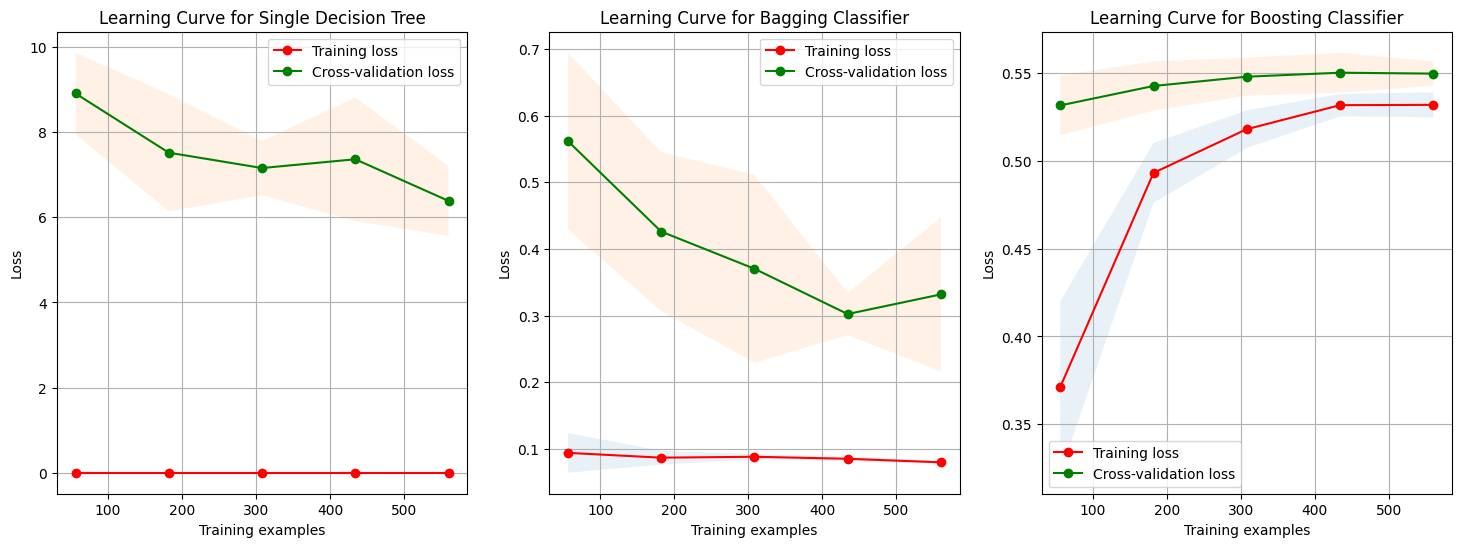

In [16]:
#Comparing the single decision tree and bagging method
compare_learning_curve([tree_model,bagging_model,boosting_model],["Single Decision Tree","Bagging Classifier","Boosting Classifier"], X_train_synth_scaled,y_train_synth) 

From the graph above, we observed that
<h4> Single Decision Tree </h4>
 Training loss of the single decision tree is very low indicating the model fits the training data extremely well. Cross validation loss on the other hand started higher at a value close to 10 but shows a declining to about 6. There is also notable gap between the training and training and validation performance indicating overfitting, as the model learns significantly well on the training but performs poorly on unseen data.
<h4> Bagging Classifier </h4>
 The Training is consistently low but slightly higher than that of the single decision tree. The cross-validation starts high but reduces significantly as more training examples are added, leveling off around a loss of 0.3
<h4>Boosting Classifier </h4>
The training starts higher but converges closely to the cross-validation loss over more training examples. The cross validation loss initially high but decreases as more training examples are used and stabilizing around 0.5

<h4>General Observation</h4>
The single decision tree overfits significantly but Both bagging and boosting show better generalization capabilities. Boosting in particular, demonstrate a reduction in overfiting by aligning training and validation losses over a large number of the training examples. On performance Bagging shows the lowest cross-validation loss among the three suggesting it might be the most robust model for the synthetic dataset in terms of generalization.

We also set up a single Support Vector Classifier, Bagging Classifer and Boosting(AdaBoostClassifier) using Support Vector classifier as their base model and evaluate their performance using the learning curve


In [43]:
#Single Model using Support Vector Classifier
svc_model = SVC(random_state=42,probability=True)
#Boosting Classifier and training
bagging_model_svc = BaggingClassifier(estimator=svc_model, n_estimators=10, random_state=42)
#Boosting Classifier and training
boosting_model_svc = AdaBoostClassifier(estimator=svc_model, n_estimators=10, algorithm='SAMME', random_state=42)

Scenario 2: Comparing a Support Vector Classifier(SVC) with Bagging and Boosting using SVC as base classifier for baggging and boosting on synthetic data.Their performance are visualized using the learning curve


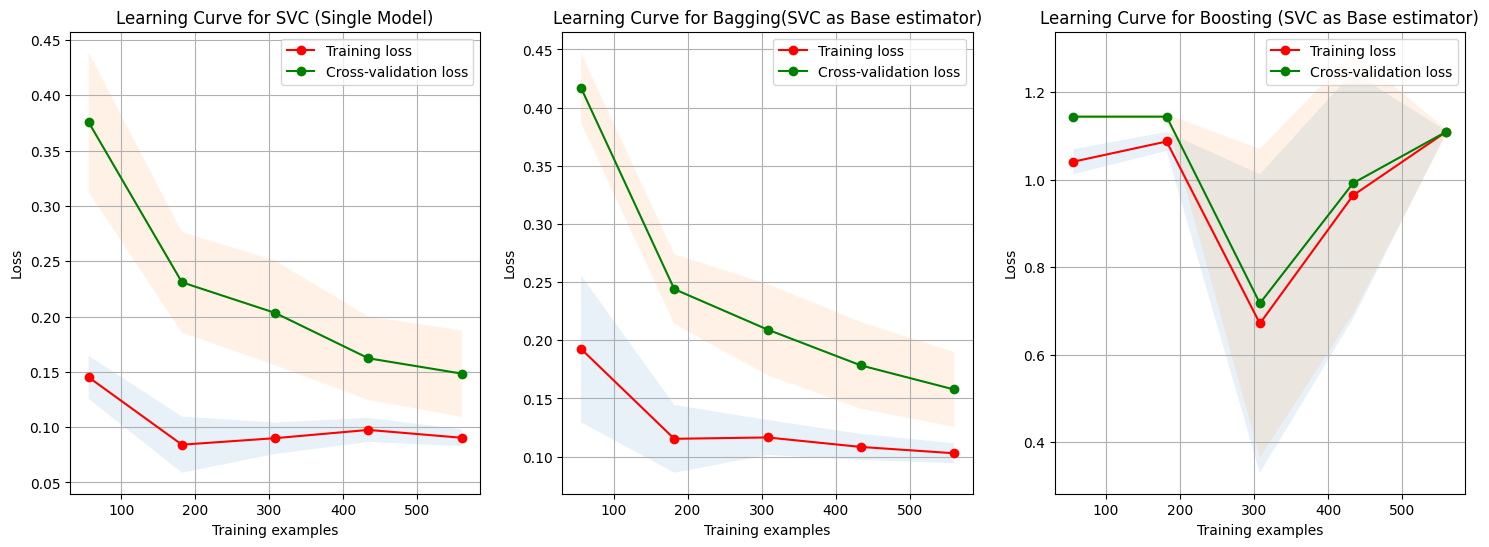

In [44]:
#Comparing the SVC and Bagging and Boosting using svc as base classifier
compare_learning_curve([svc_model,bagging_model_svc,boosting_model_svc],["SVC (Single Model)","Bagging(SVC as Base estimator)","Boosting (SVC as Base estimator)"], X_train_synth_scaled,y_train_synth) 

From the graph above, we observed that
<h4> Support Vector Classifier (SVC) </h4>
The training loss of SVC shows a gradual decrease as more training samples are used, eventually stabiling around 0.1. The cross-validation loss started higher compared to the training loss but decreases  almost converges with the training loss as more data is added.
<h4> Bagging Classifier </h4>
On the issue of the Bagging Classifier the training loss was reduces significantly with more data, becoming very low. Similar to the single SVC, the cross-validation loss started higher but quickly reduces as the number of training examples increases.
<h4>Boosting Classifier </h4>
The training loss shows a  sharp decrease between 200 and 300 training examples, then increases slightly before decreasing again.The cross validation mirrors the the training examples with a sharp dip and subsequent rise, before improving again, with more training examples. 

<h4>General Observation</h4>
We learn from the graph that, the single SVC and bagging exhibits less overfitting as they show good convergence of training and cross-validation losses. Boosting while effective in reducing error shows more variation in performance, possibly indicating sensitivity to training data distribution. In terms of performance Bagging appears to offer the most stable improvement in performance.

#### Real World Data
Having gotten a fair idea on how the models perform on the synthetic data, we found out how does the models  behaviour translate into a real world dataset. In this part therefore we experiment on real world  data to simulate the behaviour of the models with regards to overfitting. We use the Email classification dataset from UCI Machine Learning Repository which has the sample size of 4,601 instances, 57 attributes and two classes spam (1) and non-spam(0)

Loading the datasets using fetch_openml and scaling 

In [45]:
#Load the spam dataset(Real world data) using fetch_openml 
from sklearn.datasets import fetch_openml
spambase = fetch_openml(name='spambase',version=1)
#separating the features and the targets
X = spambase.data
y=spambase.target

#Spliting the data into training and validation 
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X, y, test_size=0.3, random_state=42)

#Scaling the dataset
X_train_real_scaled = scaler.fit_transform(X_train_real)
X_test_real_scaled = scaler.fit_transform(X_test_real)

Scenario 3: Comparing a single decision tree with Bagging and Bossting using Decision tree as base classifier for baggging and boosting on a real-world dataset.Their performance are visualized using the learning curve

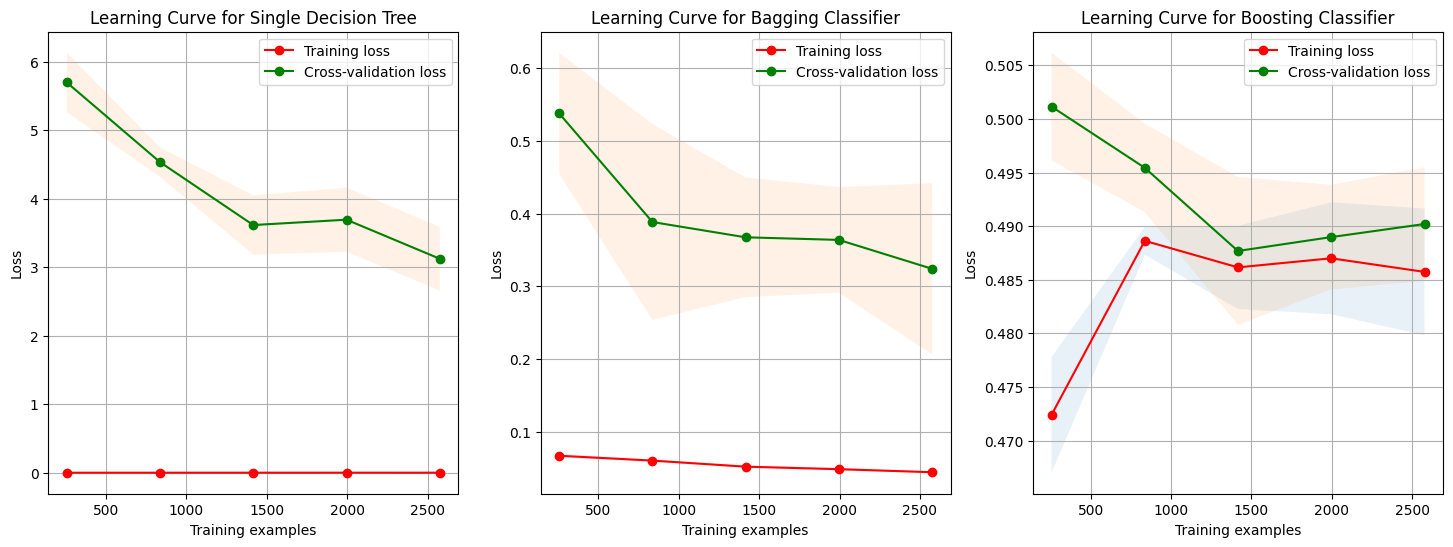

In [46]:
compare_learning_curve([tree_model,bagging_model,boosting_model],["Single Decision Tree","Bagging Classifier","Boosting Classifier"],X_train_real_scaled, y_train_real) 

From the graph of the real world data we we observed that
<h4> Single Decision Tree </h4>
The training loss and consistent with the synthetic data remains very low throught the addition of trianing samples, which suggest the model fits the training data well. The cross-validation loss started high and decreases as more training examples are added but there is a significant gap between the training and validation loss, indicating that the model is overfitting  
<h4> Bagging Classifier </h4>
The training loss remains low, similar to the single decision tree, indicating that each tree in the ensemble fits the training data well. There is also significant low loss on the cross validation as compared to a single decision tree and showing decline as more training examples are used.
<h4>Boosting Classifier </h4>
The training loss starts higher than the bagging and single decision tree models. The cross validation loss initially start similar to the single decision tree but exhibits an interesting pattern, decreasing sharply as more training data is added then fluctuates before stablizing. This volatility can be attributed to the adaptive nature of boosting, which adjusts weights to misclassified examples and can be sensitive to noise in the real-world data.

<h4>General Observation</h4>
we observed that the single decision tree model shows the most overfitting, as indicated by the low training loss and high validation loss. The bagging model improves significantly in mitigating the overfiting as compared to single model. Boosting model initially was volatile but shows potential balancing the bias-variance trade-off effectively.



Scenario 4: Comparing a Support Vector Classifier(SVC) with Bagging and Boosting using SVC as base classifier for baggging and boosting on Real-world data .Their performance are visualized using the learning curve


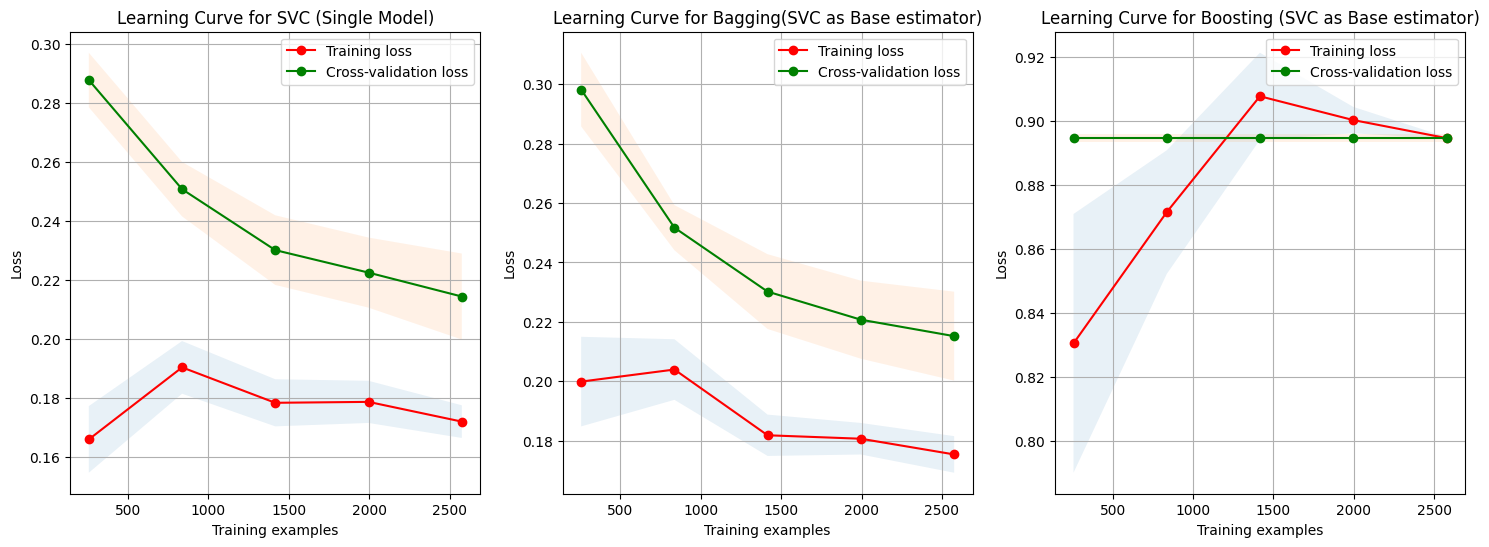

In [47]:
#Comparing the SVC and Bagging and Boosting using svc as base classifier
compare_learning_curve([svc_model,bagging_model_svc,boosting_model_svc],["SVC (Single Model)","Bagging(SVC as Base estimator)","Boosting (SVC as Base estimator)"], X_train_real_scaled, y_train_real) 

From the graph above, we observed that
<h4> Support Vector Classifier (SVC) </h4>
The training loss of support vector is relatively stable and low, showing a slight increase in performance as more training examples are used. The cross-validation starts high and decreases significantly converging towards the training loss which indicates improvement in the model genaralization with more data.
<h4> Bagging Classifier </h4>
The bagging classifier maintains a very low profile similar to that of the single SVC. The cross-validation loss decreases as more training examples are added similar to the single SVC. 
<h4>Boosting Classifier </h4>
The training loss shows a sharp increase initially to a point before it stabilizes. The cross validation loss starts high, similar to the training loss but decreases slightly and then remains stable indicating that the model is not generalizing as effectively as the bagging ensemble.

<h4>General Observation</h4>
The single SVC model demonstrate a potential overfitting at the beginning with higher higher validation losses, which improves as more data is added. The bagging shows the most effective reduction in overfiting. The Boosting seems to struggle with generalization in this scenario, possibly due to the increase complexity and sensitivity of the boosting process with SVC. On the performance Bagging with SVC base classifiers seems to be the most effective in the real-world dataset. 

<h4>Conclusion</h4>
In comparing the performance of the single models with the ensemble methods with their ability to mitigate overfitting across both synthetic and real-world datasets, the results consistently indicate  that the ensemble methods particularly the bagging excel in mitigating overfitting and improving model generalization over single models like decision trees and SVCs. Bagging shows a robust capability to reduce variance, consistently lowering cross-validation loss closer to training loss across different scenarios and datasets. Boosting while effective in reducing bias and sometimes variance, exhibits higher sensitivity to training data variations resulting in less stable performance, particulary using complex models like SVC as base estimator. 

# RESEARCH QUESTION 3

 # ***In the case of SVM, what is the impact of class overlap, class unbalance and mislabeled data on the number and location of support vectors?***

   
   
   
   
   # INTRODUCTION                 

#  Class unbalance, class overlap and mislabeled data

 #### Class unbalance occurs when the number of class in one set is of greater proportion as compare to the number of class of the other set (In the case of a supervised learning). Generally, this is a problem that every machine learning learners will encounter especially when dealing with real world data, such as medical data. This tend to cause the machine learning model to be biased toward the learning of the majority class, thus reducing the performance of the model. https://www.sciencedirect.com/science/article/abs/pii/S0031320323004193 .



 #### Class overlap is a situation where different data points have belonging to different classes share commong value belonging to a feature. This decreases the performance of the model which tend not to differentiate between different class. Moreover, if this situation is coupled with an unbalanced data set, the model will tend to biased towards the makority class as seen in the class unbalanced situation.

#### Mislabeled data occurs when the outout label for a data point does not correspond with the true label. This introduces noise to the data and causes the machine learning model to do false predictions. This can also lead to overfiting since the model might perform well on the trained data with the provided output lable but fails to generalize on the test data.https://www.linkedin.com/pulse/computer-vision-classification-cleaning-noisy-mislabeled-data/.

We have seen how class unbalance, class overlap and mislabeled data can impact the machine learning model in a very negative way. Now we will introduce a powerful classifier, and illustrate how this challenges impact the classifier.

## Surport Vector Machine (SVM)

SVM is a powerful maching learning algorithm used for both classification and regression problems. But in this illustraions, we will moslty focus SVM in the case of classification problems. 

The idea of SVM is to find a hyperplane (which is a decision boundary) that best seperate the data into different classes. This is generally done by maximizing the distance between the hyperplane and the closest point of each classes ( known as the margin).
These closest point also determines the hyperplane and are know as support vectors.
https://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf

This can be illustrated in the diagram below. The visualization of the support vectors, the margins and the hyperplane has been taken from the scikit-learn website.  https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html.

### Importing the necessary libaries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

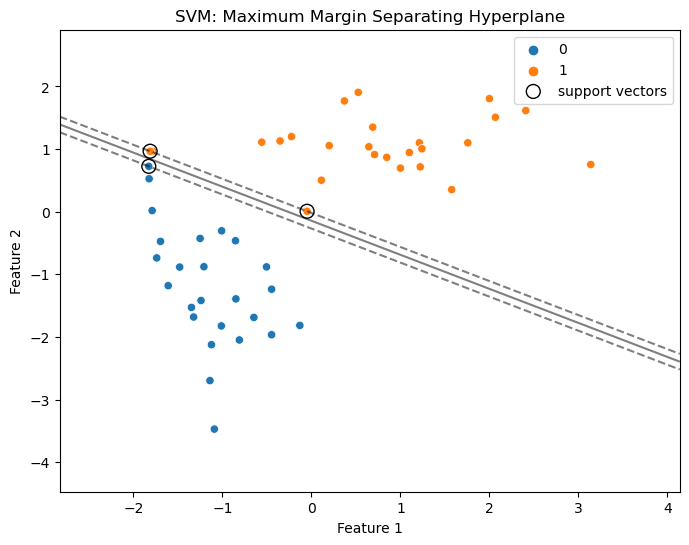

In [57]:

np.random.seed(42)
# Generate a sample dataset
X, y = make_classification(n_samples=50, n_features=2, n_classes=2,  n_clusters_per_class=1, random_state=6,n_redundant=0)

# Train an SVM classifier with a linear kernel
clf = SVC(kernel="linear", C=1000)
clf.fit(X, y)



# Visualize the support vectors, margins, and hyperplane
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X),x=0,y=1,hue=y)

# Plot the decision boundary and margins
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax
)

# Plot the support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
)
plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Working principle


Firstly, the algorthm detects different hyperplanes that seperates the data by maximising the margin. - 

That is given a data set $D=\{(\textbf{x}_1,y_1),..., (\textbf{x}_n,y_n)\}$, where $\textbf{x}_i\in X\subset \mathbb{R}^m, y_i\in Y=\{+1,-1\}$ and the decision funtion $f(x)=w\cdot \textbf{x}-b$ where $w$ is the vector of the hyperplane which determines the orientation and $b$ the bias which determines the positioning.

It finds the margin and the position of the hyperplane by finding the minimum distance between the plane and the closest data point. This distance is measured by calculating the line orthogonal to the plane and passes through the data point. That is, it finds the orthorgonal projection $P$ of the data point onto the vector $w$. This is given by $$P=\frac{\textbf{w}^T\textbf{x}}{||w||}.$$

Thus having two margins (one at one class and the other on the other class), the hyperplane is always a plane at the middle of the margins and this is determined and positioned as seen by the equation by the closest points to the plane since these are the points that helps construct the margins.

The power behind the support vector machine is to incerease the prediction confidence by choosing the appropriate plane which best maximizes the margin.

In summary, this best plane is obtained by solving the Lagarangian optimization problem given by $$L(\alpha)=\sum_{n=1}^{N}\alpha_n-\frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N}y_ny_m\alpha_n\alpha_m\textbf{x}_n^T\textbf{x}_m$$, where we wish to maximise with respect to $\alpha$, subject to $\alpha_n\geq 0$, $n=1,...,N$ and $$\sum_{n=1}^{N}\alpha_ny_n=0.$$ This leads to the the desition funtion below $$ f(x)=sign\left(\sum_{n=1}^{N}\alpha_ny_n\cdot \textbf{x}-b\right)$$ where $\sum_{n=1}^{N}\alpha_ny_n\cdot \textbf{x}-b$ refers to the measure of the distance of a vector $\textbf{x}$ to the hyperplane and the the sign funtion refers to the label.


Hence the support vectors is thus the portion of the training vectors where the the associated $\alpha's$ are greater than zero$. (Lecture notes: SFML-Lecture08 and
https://upcommons.upc.edu/bitstream/handle/2117/110122/JoC_Camera_Ready_Revision1.pdf?sequence=1





In this case, we can see that that the support vector machine find the best hyperplane which seperated the classe perfectly with the help of 3 support vectors, one vector in the blue dataset and the  two other in the orange. The position of the hyperplane is highly inflenced by the support vectors. Up till now, we have be dealing with a balanced data. That we had 50 data points each equally distributed (25 data points for each classes).  Now let us illustrate how the number of support vectors and the location varies when dealing with unbalanced data set.
.



### Support Vector Machine with class in balance

Below, we add weight to the given classes and see the behaviour of the support vectors of each of the following class. As the training data gets more imbalanced, the ratio between the majority and minority class's support vectors also becomes more imbalanced.  In such cases, it has been
observed that the hyperplane separation learned by the SVM is very close to the minority class. https://sci2s.ugr.es/keel/pdf/specific/congreso/akbani_svm_2004.pdf

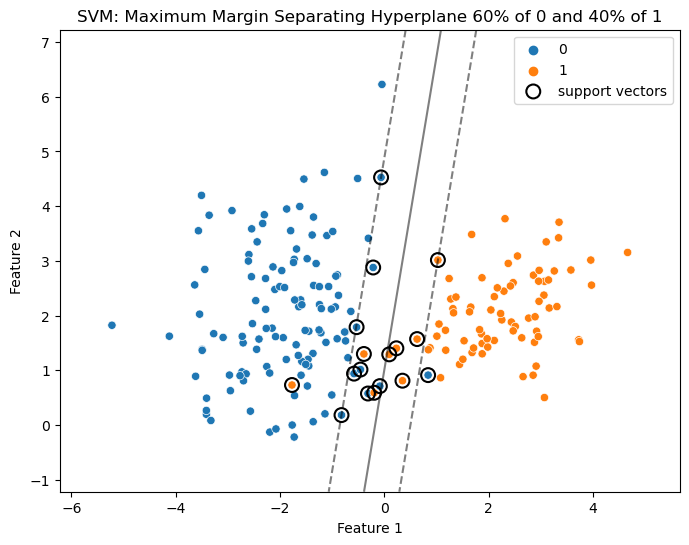

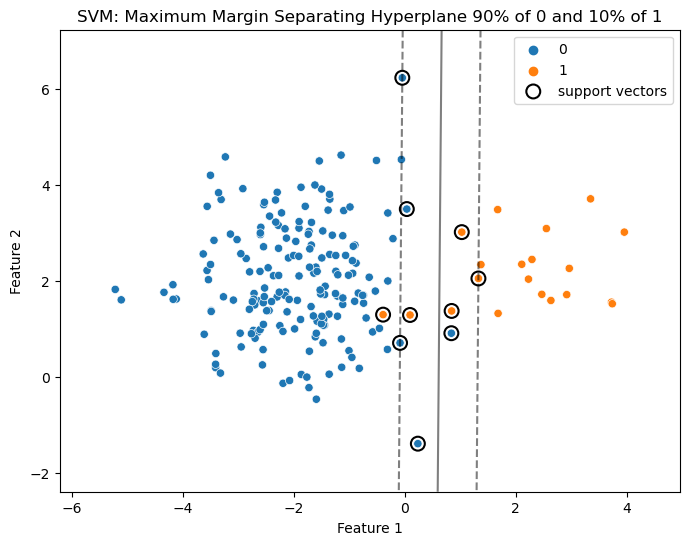

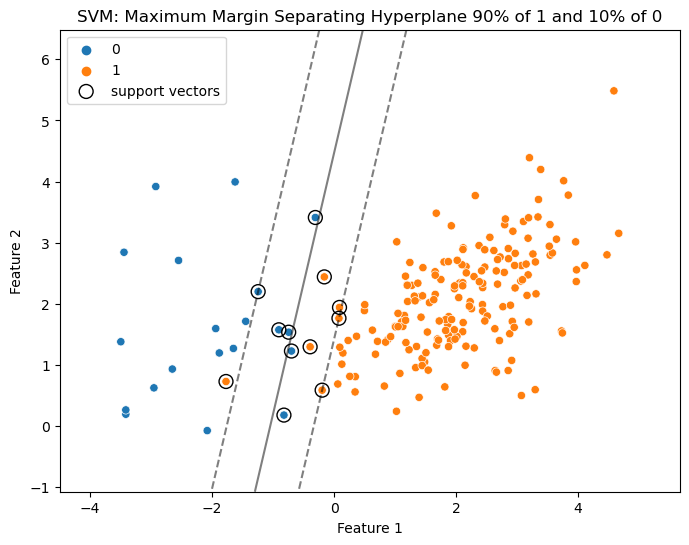

In [69]:

np.random.seed(42)
# Generate a sample slightly imbalanced dataset with  60% of the class belonging to class 0 and 40% belonging to class 1
X, y = make_classification(n_samples=200, n_features=2, n_classes=2,  n_clusters_per_class=1, random_state=42,n_redundant=0,
                           weights=[0.6,0.4],n_informative=2, class_sep=2)

# Generate a sample dataset with  90% of the class belonging to class 0 and 10% belonging to class 1
X_0, y_0 = make_classification(n_samples=200, n_features=2, n_classes=2,  n_clusters_per_class=1, random_state=42,n_redundant=0,
                           weights=[0.9,0.1],n_informative=2, class_sep=2)

# Generate a sample dataset with  70% of the class belonging to class 1 and 30% belonging to class 0
X_1, y_1 = make_classification(n_samples=200, n_features=2, n_classes=2,  n_clusters_per_class=1, random_state=42,n_redundant=0,
                           weights=[0.1,0.9],class_sep=2)

# Train an SVM classifier with a linear kernel
clf = SVC(kernel="linear")
clf_1 = SVC(kernel="linear")
clf_2=SVC(kernel="linear")
clf.fit(X, y)
clf_1.fit(X_0, y_0)
clf_2.fit(X_1, y_1)

# Visualize the support vectors, margins, and hyperplane
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X),x=0,y=1,hue=y)

# Plot the decision boundary and margins
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax
)

# Plot the support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1.5,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
     
)
plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane 60% of 0 and 40% of 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



# Visualize the support vectors, margins, and hyperplane
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X_0),x=0,y=1,hue=y_0)

# Plot the decision boundary and margins
ax_1 = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf_1, X_0, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax_1
)

# Plot the support vectors
ax_1.scatter(
    clf_1.support_vectors_[:, 0],
    clf_1.support_vectors_[:, 1],
    s=100,
    linewidth=1.5,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
     
)
plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane 90% of 0 and 10% of 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X_1),x=0,y=1,hue=y_1)

ax_2 = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf_2, X_1, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax_2
)


# Plot the support vectors
ax_2.scatter(
    clf_2.support_vectors_[:, 0],
    clf_2.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
)



plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane 90% of 1 and 10% of 0")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


plt.show()


#### In the following figure above, we could observe that the support vectors varies for different case. 

On graph 1, there is a slight percentage of class imbalance with a 60% of class 0 and 40% of class 1. Here we can see that the support vectors of both classes though not thesame, but nearly equal and are both trying to be position near the boundary decision. Hence we can still visualise the hyperplane which best seperates the classes.

below on graph 2, the 0 class is the majority class with 90%, the number of the support vectors tends  to be less as compared to the one class (orange). Furthermore, the support vectors of the class 1 which is the minority tends to be positionned close to the boundary decision, whereas that of the majority class 0 is positioned further appart from the boundary decision. As we can see on the figure 1, this caused the hyperplane to be more on the side of the minority class hence causing the model to be biased towards the majority class.

 
 Similarly, the same observation is made on the reverse side, that is when there is more ones than zeros.   the number of the support vectors tend to be more at the zero class (blue) as compared to the orange class (majority). Again the support vectors of the class 0 tends to be more position close to the boundary decision, whereas that of the majority class 1 is positioned further from the boundary decision. As we can see on the figure 2, this caused the hyperplane to be more on the side of the minority class hence causing the model to be biased towards the majority class 0


This reason is due to the fact that the Support Vector Machine as said in the introduction tends to find the best hyperparameter which maximize the margins and also minimizes the error. Hence in other to have the best hyperparameter, which seperates the class with the least error as possible,  more weight $\alpha$ is given to the support vectors of the minority class, and less to the majority class and this tend to be more observed when the data becomes extremely imbalance . 
https://sci2s.ugr.es/keel/pdf/specific/congreso/akbani_svm_2004.pdf




### Support Vector Machine with mislabeled data

In this section, we visualize the behaviour of the support vectors when the data are mislabeled. In order to obtain a mislabeled synthetic data we use the parameter flip.

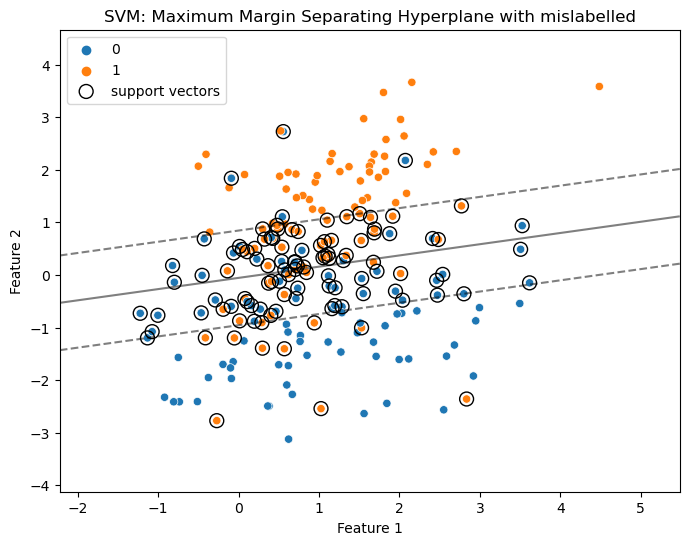

In [14]:
X, y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.1,
    random_state=42
)
# Train an SVM classifier with a linear kernel
clf = SVC(kernel="linear", C=1.0)
clf.fit(X, y)



# Visualize the support vectors, margins, and hyperplane
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X),x=0,y=1,hue=y)

# Plot the decision boundary and margins
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax
)

# Plot the support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
)
plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane with mislabelled")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

 In the case of  the mislabeled  data, this leads to incorrect  support vectors. As such even some of the mislabeled data might be considered to be support vectors. The SVM tries to fit a hyperplane that best separates the classes, but mislabeled points cause the algorithm to place the boundary in a less optimal position, leading to more points being on or near the margin. In the case of a perfect data as seen in the first plot above, One could also observe that the support vectors tends to be more located around the decision boundary.
 
Since some of the mislabeled data might also be considered, they position of the support vectors will be dispersed  but also more clustered to the decision boundary in order to find the optimal hyperpalen as seen on the figure above.
 
 
 

### Support Vector machine on Class overlap

We now visualize the behaviour of the support vectors on the class overlap. We create this class overlap with the parameter class_sep


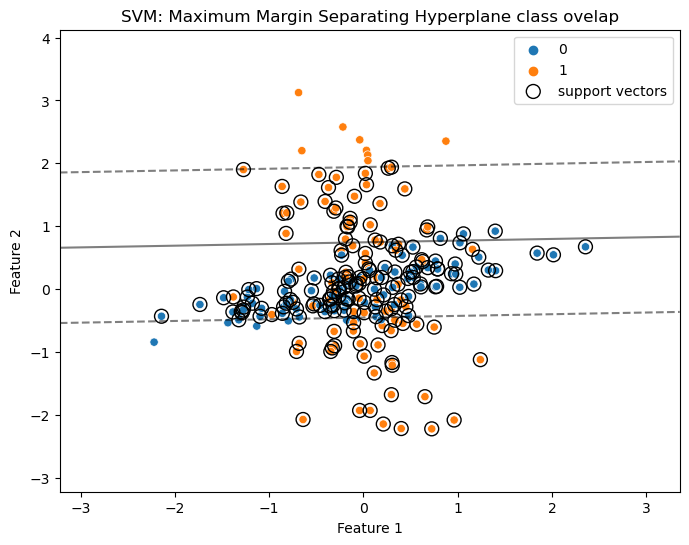

In [15]:
X, y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0,
    random_state=0
)


# Train an SVM classifier with a linear kernel
clf = SVC(kernel="linear", C=10000)
clf.fit(X, y)



# Visualize the support vectors, margins, and hyperplane
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X),x=0,y=1,hue=y)

# Plot the decision boundary and margins
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax
)

# Plot the support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
)
plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane class ovelap")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

 From this diagram, we can see that if there is class overlap the the number of support vectors tend to increase in order to find the best hyperplane that seperates the classes. Moreoever, the support vectors tend to be more concentrated and positioned at the level of the overlap.
 
 That is, overlapping classes generally increases the number of support vectors. This is because the support vector Machine tries to maximize the margin between classes, and with overlapping data, more points are close to the decision boundary, becoming support vectors.


In this case as observed on the diagram, the support vectors are likely to be located near the overlapping regions because these are the points that are most difficult to classify. The SVM places the decision boundary in such a way that it tries to accommodate the overlapping data points, resulting in more support vectors around the boundary.

# Conclusion

##### To conlcude, support vectors machine is can be sensitive to different data it is trained on since different data tend to influence the number and location of the support vectors which are important for the positioning of the hyperplane. Class inbalance and class overlap which tends to increase the number of support vectors and the class overlap which increase the support vector in the minority class.



For future research, it will be insteresting to see how the role of the hyper parameters can influence the support vector on these three data set (mislabelled, overlap and unbalanced), as seen below, where the kernel has been changed from linear to rbf in the case of class overlap, choosing the appropriate hyper parameter can be very uselful to overcome these different challaages with the support vector machine

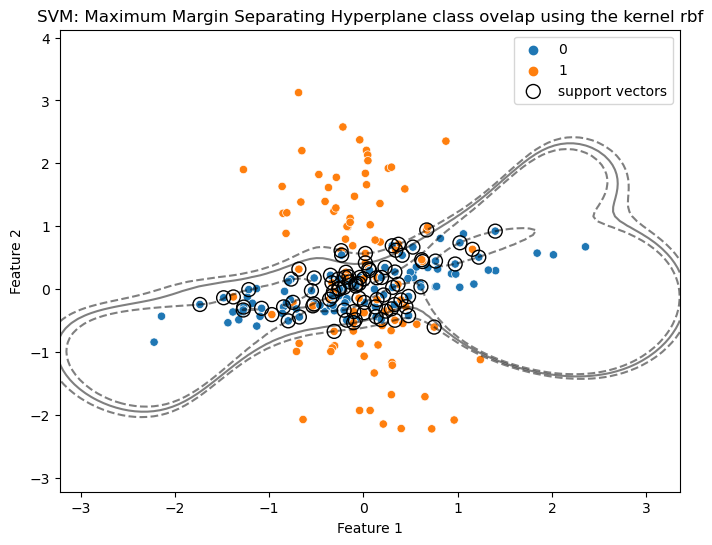

In [3]:
X, y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0,
    random_state=0
)


# Train an SVM classifier with a linear kernel
clf = SVC(kernel="rbf", C=10000)
clf.fit(X, y)



# Visualize the support vectors, margins, and hyperplane
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pd.DataFrame(X),x=0,y=1,hue=y)

# Plot the decision boundary and margins
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf, X, plot_method="contour", colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"], ax=ax
)

# Plot the support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
    label='support vectors'
)
plt.legend()
plt.title("SVM: Maximum Margin Separating Hyperplane class ovelap using the kernel rbf")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Reference List
1. Dietterich, T.G. (2000). Ensemble Methods in Machine Learning. In: Multiple Classifier Systems. MCS 2000. Lecture Notes in Computer Science, vol 1857. Springer, Berlin, Heidelberg. https://doi.org/10.1007/3-540-45014-9_1
2. Opitz, D., & Maclin, R. (1999). Popular ensemble methods: An empirical study. Journal of artificial intelligence research, 11, 169-198.
3. https://www.upgrad.com/blog/bagging-vs-boosting/
4. https://machinelearningmastery.com/essence-of-boosting-ensembles-for-machine-learning/
5. Demir, N. (2016). Ensemble methods: Elegant techniques to produce improved machine learning results. Toptal. com.
6. https://corporatefinanceinstitute.com/resources/data-science/boosting/
7. https://medium.com/@brijesh_soni/understanding-boosting-in-machine-learning-a-comprehensive-guide-bdeaa1167a6
8.https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
9.https://www.geeksforgeeks.org/why-an-increasing-validation-loss-and-validation-accuracy-signifies-overfitting/
10. https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
11. https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/
12. https://discuss.pytorch.org/t/does-my-loss-curve-show-the-model-is-overfitting/184039

